In [1]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Flatten, Concatenate
from tensorflow.keras.models import Model

In [2]:
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
HIDDEN_DIM = 256  # Latent dimensionality of the encoding space.
EMBEDDING_DIM = 64
NUM_SAMPLES = 33000  # Number of samples to train on.

In [3]:
def unicode_to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [4]:
def preprocess_sentence(sent):
    # 악센트 삭제 함수 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent

In [5]:
# dataset
eng_corpus, fra_corpus = [], []
with open(r"fra-eng\fra.txt", "r") as lines:
    for i, line in enumerate(lines):
        # source 데이터와 target 데이터 분리
        tar_line, src_line, _ = line.strip().split('\t')

        eng_corpus.append(tar_line)
        fra_corpus.append(src_line)

print(len(eng_corpus), eng_corpus[:10])
print(len(fra_corpus), fra_corpus[:10])

227815 ['Go.', 'Go.', 'Go.', 'Go.', 'Hi.', 'Hi.', 'Run!', 'Run!', 'Run!', 'Run!']
227815 ['Va !', 'Marche.', 'En route !', 'Bouge !', 'Salut !', 'Salut.', 'Cours\u202f!', 'Courez\u202f!', 'Prenez vos jambes à vos cous !', 'File !']


In [6]:
encoder_input, decoder_input, decoder_target = [], [], []

for i, (src_line, tar_line) in enumerate(zip(fra_corpus, eng_corpus)):
    # source 데이터 전처리
    src_line = [w for w in preprocess_sentence(src_line).split()]

    # target 데이터 전처리
    tar_line = preprocess_sentence(tar_line)
    print('tar_line : ', tar_line)

    tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋
    print('tar_line in : ', tar_line_in)

    tar_line_out = [w for w in (tar_line + " <eos>").split()]
    print('tar_line out: ', tar_line_out)

    encoder_input.append(src_line) # 클리닝
    decoder_input.append(tar_line_in) # 클리닝 + sos
    decoder_target.append(tar_line_out) # 클리닝 + eos

    if i == NUM_SAMPLES - 1:
        break
    break

tar_line :  go .
tar_line in :  ['<sos>', 'go', '.']
tar_line out:  ['go', '.', '<eos>']


In [7]:
def load_preprocessed_data(eng_corpus, fra_corpus):
    encoder_input, decoder_input, decoder_target = [], [], []

    for i, (src_line, tar_line) in enumerate(zip(fra_corpus, eng_corpus)):
        # source 데이터 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]

        # target 데이터 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line) # 클리닝
        decoder_input.append(tar_line_in) # 클리닝 + sos
        decoder_target.append(tar_line_out) # 클리닝 + eos

        if i == NUM_SAMPLES - 1:
            break

    return encoder_input, decoder_input, decoder_target

In [8]:
sents_fra_in, sents_en_in, sents_en_out  = load_preprocessed_data(eng_corpus, fra_corpus)

In [9]:
# 프랑스어 (encoder)
tokenizer_enc = Tokenizer(filters="", lower=False)
tokenizer_enc.fit_on_texts(sents_fra_in)

# 인코더 데이터
encoder_input = tokenizer_enc.texts_to_sequences(sents_fra_in)

In [10]:
# 영어 (decoder)
tokenizer_dec = Tokenizer(filters="", lower=False)
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)

# 디코더 데이터
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)

In [11]:
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1

print(f"프랑스어 단어 집합의 크기 : {SRC_VOCAB_SIZE}, 영어 단어 집합의 크기 : {TAR_VOCAB_SIZE}")

프랑스어 단어 집합의 크기 : 7871, 영어 단어 집합의 크기 : 4483


In [12]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]

In [13]:
src2idx = tokenizer_enc.word_index  # word : idx
idx2src = tokenizer_enc.index_word  # idx : word
tar2idx = tokenizer_dec.word_index # word : idx
idx2tar = tokenizer_dec.index_word # idx : word

In [14]:
# 랜덤 인덱스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

# 랜덤하게 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

랜덤 시퀀스 : [23130  3311 18593 ... 12006 21967 26522]


In [15]:
n_of_val = int(NUM_SAMPLES*0.1) # 900

# train data
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test data
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

### encoder, decoder modeling

In [16]:
# 인코더 (Train)

## 층
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM)
encoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state = True) # 상태값 리턴을 위해 return_state는 True


## input -> output
encoder_inputs = Input(shape=(None, ))
enc_emb = enc_emb_layer(encoder_inputs)
encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb)

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 리스트로 저장

In [17]:
# 디코더 (Train)

## 층
#상태값 리턴을 위해 lstm layer return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
decoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state = True)
decoder_att_layer = Attention()
decoder_flat_layer = Flatten()
decoder_dense_layer = Dense(TAR_VOCAB_SIZE, activation = 'softmax')


## input -> output
# 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_inputs = Input(shape=(MAX_DEC_LEN, ))
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)
# Attention, Flatten 추가
decoder_att = decoder_att_layer([decoder_outputs, encoder_outputs])
print(decoder_att)
print(decoder_outputs)
decoder_concat = Concatenate(axis = 2)([decoder_att, decoder_outputs])
print(decoder_att)
# decoder_flat = decoder_flat_layer(decoder_concat)
# print(decoder_flat)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_outputs = decoder_dense_layer(decoder_concat)
print(decoder_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 256), dtype=tf.float32, name=None), name='attention/MatMul_1:0', description="created by layer 'attention'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 256), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 256), dtype=tf.float32, name=None), name='attention/MatMul_1:0', description="created by layer 'attention'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 4483), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [18]:
decoder_outputs

<KerasTensor: shape=(None, 8, 4483) dtype=float32 (created by layer 'dense')>

In [19]:
decoder_outputs

<KerasTensor: shape=(None, 8, 4483) dtype=float32 (created by layer 'dense')>

In [20]:
# 모델의 입력과 출력을 정의.
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     503744      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 8, 256)       1147648     ['input_2[0][0]']                
                                                                                              

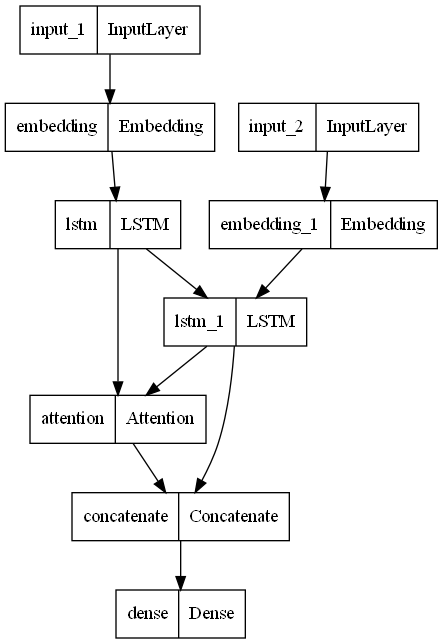

In [21]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [22]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

history = model.fit(x = [encoder_input_train, decoder_input_train],
                    y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = BATCH_SIZE, callbacks = [earlystopping], epochs = 1)

465/465 [==============================] - 33s 64ms/step - loss: 2.6506 - acc: 0.5799 - val_loss: 2.1551 - val_acc: 0.6385


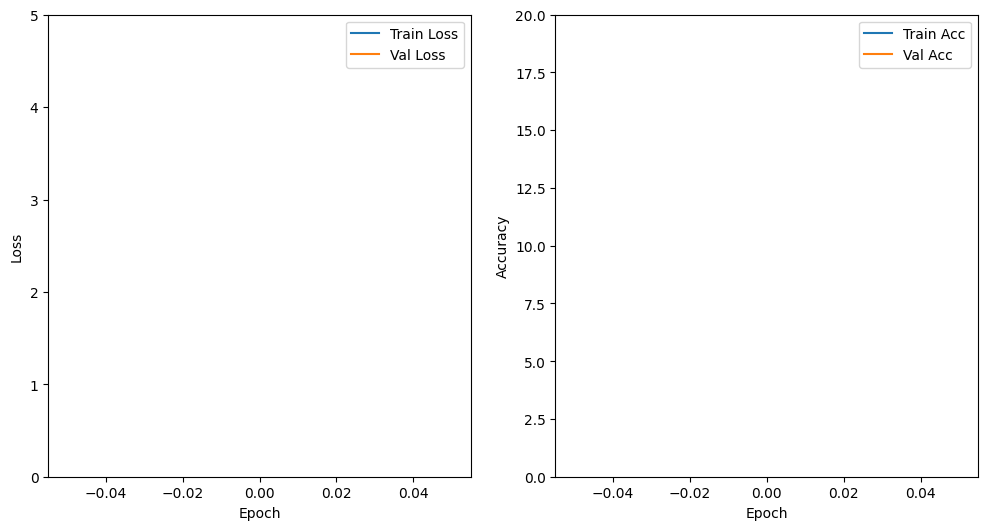

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12, 6))

    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='Train Acc')
    plt.plot(hist['epoch'], hist['val_acc'], label = 'Val Acc')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

In [24]:
### 번역기 만들기

In [25]:
# 인코더 - 훈련과 동일
encoder_model = Model(encoder_inputs, encoder_states)

In [33]:
# 디코더 (Predict)

# Input Tensors : 이전 시점의 상태를 보관할 텐서
decoder_input_h = Input(shape=(HIDDEN_DIM,))
decoder_input_c = Input(shape=(HIDDEN_DIM,))

decoder_states_inputs = [decoder_input_h, decoder_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
x = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h2, state_c2 = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_att = decoder_att_layer([x, encoder_outputs])

# 모든 시점에 대해서 단어 예측 (Fully Connected)
conc = Concatenate(axis = 2)([x, decoder_att])
flatt = decoder_flat_layer(conc)
x = decoder_dense_layer(flatt)

# 수정된 디코더
decoder_model = Model(
    inputs = [decoder_inputs] + decoder_states_inputs,
    outputs = [x] + decoder_states2)

ValueError: Exception encountered when calling layer "dense" (type Dense).

Dimensions must be equal, but are 4096 and 512 for '{{node dense/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](Placeholder, dense/MatMul/ReadVariableOp)' with input shapes: [?,4096], [512,4483].

Call arguments received by layer "dense" (type Dense):
  • inputs=tf.Tensor(shape=(None, 4096), dtype=float32)

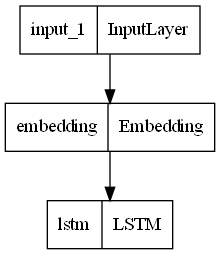

In [28]:
tf.keras.utils.plot_model(encoder_model)

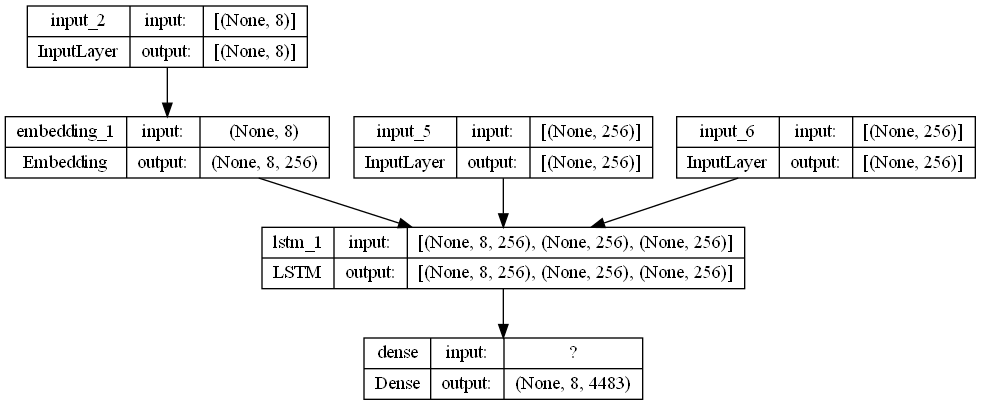

In [29]:
# 디코더 모델 시각화
tf.keras.utils.plot_model(decoder_model, show_shapes = True)

In [30]:
def translate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # 입력 문장 토큰 -> 라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens])

    # 입력 문장 라벨링 -> 패딩
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
    states_value = encoder_model.predict(enc_input)

    # Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar2idx['<sos>']


    # prediction 시작
        # stop_condition이 True가 될 때까지 루프 반복
        # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    stop_condition = False
    decoded_sentence = ''

    for t in range(MAX_DEC_LEN):

        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :])
        result_word = idx2tar[result_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+result_word

        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = result_token_index

        # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
        states_value = [h, c]

        #  Stop condition <eos>에 도달하면 중단.
        if result_word == '<eos>':
            break

    return decoded_sentence.strip(' <eos>')

In [31]:
train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:]
n_samples = 5
np.random.choice(train_idx, n_samples)
# train data - translate
n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = fra_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 396ms/step


ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\mzp\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\mzp\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\mzp\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\user\anaconda3\envs\mzp\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\user\anaconda3\envs\mzp\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\anaconda3\envs\mzp\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_2" "                 f"(type Functional).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 512, but received input with shape (None, 1, 256)
    
    Call arguments received by layer "model_2" "                 f"(type Functional):
      • inputs=('tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)')
      • training=False
      • mask=None
